In [1]:
#lancer la communication asynchrone avec thymio
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node fbffd2bf-1e6b-4546-b240-60eed16c9df4

In [2]:
# Premade libraries
import cv2
import time
import math
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, Point, LineString

# Homemade functions
import Vision.vision as vs
import robot as rbt
import Global_Navigation.global_navigation as glb
import Motion_Control.thymio_control as ctrl

In [3]:
def get_angle2goal(geometry, goal):
    """
    Compute the angle between the curent orientation of the tymio and its next goal
    :return: beta the angle btw goal/crt orientation
    """
    beta = math.atan2(goal[1] - geometry[1], goal[0] - geometry[0])
    if beta - geometry[2] < -np.pi:
        beta = -(beta - geometry[2] + np.pi)
    elif beta - geometry[2] > np.pi:
        beta = -(beta - geometry[2] - np.pi)
    else:
        beta = beta - geometry[2]
    return beta

def get_correct_orientation(beta, node, speed, tol):
    if abs(beta) < tol:
        #print("right angle")
        #ctrl.stop_motors(node)
        return(True)
    if beta < 0 :
        ctrl.set_motor_speed(speed, -speed, node)
        return(False)
    elif beta > 0:
        
        ctrl.set_motor_speed(-speed, speed, node)
        return(False)
    
def get_distance(pos, goal, tol, speed, node):
    dist = np.linalg.norm((goal[0]-pos[0], goal[1]-pos[1]))
    if dist < tol:
        ctrl.stop_motors(node)
        return True
    else:
        spLeft = speed
        spRight = speed
        for i in range(5):
            a = 4-i
            sensor = ctrl.get_prox_sensors(node,client)
            spLeft += sensor[i] * obstSpeedGain[i] // 100
            spRight += sensor[i] * obstSpeedGain[a]//100
        ctrl.set_motor_speed(spRight, spLeft, node)
        return False
    

        

In [4]:
cap = cv2.VideoCapture(1)
img = vs.get_image(cap)
margin = 80
speedGain = 2     # gain used with ground gradient
obstSpeedGain = np.array([6,4,-2,-6,-8])
thymio = rbt.RobotNav()

center1
(151.0, 239.5)
center2
(106.0, 257.0)


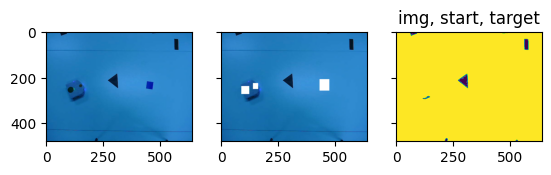

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 499.95it/s]


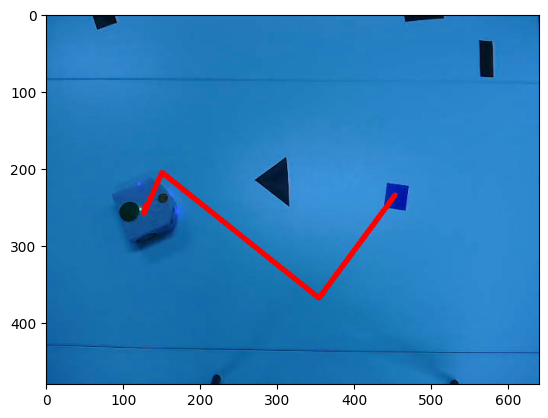

state updated


In [5]:
i = 0 #step vis graph
path = 0
while cap.isOpened():
    ret, frame = cap.read()
    
    if thymio.get_state() == 0:
        thymio.initialisation_step(img, margin, True)
        thymio.set_state(1)
        path = thymio.get_path()
    
    if thymio.get_state() == 1:  #motion control commence
        pos_thy, two_centres = vs.detect_start(frame, False, False)  #recupere pos thymio
        frame = glb.draw_thymio(frame, pos_thy)   # dessine point thymio new fenetre
        frame = glb.draw_path(frame, thymio.get_path()) #dessine chemin du thymio new fenetre
        
        thymio.update_position_cam(two_centres)  #update pos thymio et angle dans la classe robot
        if len(path) > (i+1):
            next_goal = (path[i+1].x,path[i+1].y)
            # astolfi implemetation
            angle = get_angle2goal(thymio.get_geometry(), [1,0])  #angle entre thymio et point
            temp=ctrl.astolfi(thymio.get_geometry(), angle, next_goal, node)
            if temp==1:
                i=i+1
            # jank implementation that works
        else : 
            ctrl.stop_motors(node)
        '''
            angle = get_angle2goal(thymio.get_geometry(), next_goal)  #angle entre thymio et point
            get_correct_orientation(angle, node, 50, 0.2)
            
            if get_correct_orientation(angle, node, 50, 0.2):
                print("avance")
                
                
                get_distance(thymio.get_geometry(), next_goal, 30, 200, node)
                
                if get_distance(thymio.get_geometry(), next_goal, 30, 200, node):
                    i = i + 1
                    if i == (len(path)-1):
                        thymio.set_state(2)
                        ctrl.stop_motors(node)
                        print("arrivee")
                        print(thymio.get_state())
                        break      
        '''
        
    cv2.imshow('frame',frame)     
    if cv2.waitKey(1) == ord('q'):
        ctrl.stop_motors(node)
        break
        
cap.release()
cv2.destroyAllWindows()

In [6]:
ctrl.stop_motors(node)